<a href="https://colab.research.google.com/github/c-gohlke/X_Ray-patients-classification/blob/master/MURA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anomaly Detection for Hand X-Ray Images


##Part 1: Data loading and preprocessing

We first have to access the dataset from the google drive and unzip it in our current working directory

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#mute output
%%capture

!unzip '/content/drive/My Drive/projects/MURA/MURA-v1.1.zip'

In [52]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import pickle
import sys
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.color import rgb2gray
from skimage.transform import resize

This function is what we will use to load the data. The 'MURA-v1.1/train_labeled_studies.csv' file contains the path to each patient, as well as their Diagnosis (Normal=0 vs abnormal=1).


In [16]:
def load_images(img_dim, path):
    df = pd.read_csv(path)

    x = []
    Y = []
    for i in range(len(df)):
        dirList = os.listdir(df["PATH"][i])
        for dir in dirList:
            img = mpimg.imread(df["PATH"][i] + dir) #mpimg loads images with values 0 to 1, no need to rescale
            gray = rgb2gray(img)
            image_resized = resize(img, img_dim)

            x.append(image_resized)
            Y.append(df["DIAGNOSIS"][i])

    return np.asarray(x), np.asarray(Y)

In [12]:
labels_amount = 2
img_dim = (220, 220, 3)

In [ ]:
# X_train, y_train = load_images(img_dim, 'MURA-v1.1/train_labeled_studies.csv')
# X_test, y_test = load_images(img_dim, 'MURA-v1.1/valid_labeled_studies.csv')

# with open('/content/drive/My Drive/projects/MURA/files/X_train.pickle', 'wb') as handle:
#     pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/y_train.pickle', 'wb') as handle:
#     pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_test.pickle', 'wb') as handle:
#     pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/y_test.pickle', 'wb') as handle:
#     pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('/content/drive/My Drive/projects/MURA/files/X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [47]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([4059, 1484]))
(array([0, 1]), array([271, 189]))


We see that the datasets are imbalanced. This will push the model to predict 0's much more often than 01's. To solve this problem, we can apply weights to the class according to the frequency of the classes, or we can resample the dataset such that it is balanced.

Resampling the dataset also allows the accuracy metric to be more intuitive. Indeed, a model that always predicts 0 will have an accuracy of 75%, even though the model doesn't provide any information.

In [66]:
true_train_idx, = np.where(y_train == 1)
false_train_idx, = np.where(y_train == 0)
true_test_idx, = np.where(y_test == 1)
false_test_idx, = np.where(y_test == 0)

np.random.seed(0)
false_train_idx_sampled = np.random.choice(false_train_idx, len(true_train_idx), replace=False)
false_test_idx_sampled = np.random.choice(false_test_idx, len(true_test_idx), replace=False)

resample_train_idx = np.concatenate((true_train_idx, false_train_idx_sampled))
resample_test_idx = np.concatenate((true_test_idx, false_test_idx_sampled))

X_train_balanced = X_train[resample_train_idx]
X_test_balanced = X_test[resample_test_idx]

In [67]:
y_train_cat = np_utils.to_categorical(y_train, labels_amount)
y_test_cat = np_utils.to_categorical(y_test, labels_amount)

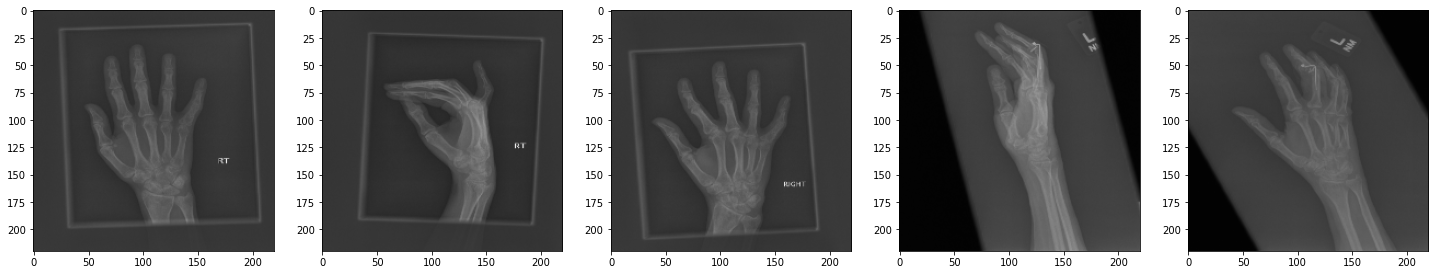

In [69]:
#example of images:
example_img1 = X_train_balanced[0]
example_img2 = X_train_balanced[1]
example_img3 = X_train_balanced[2]
example_img4 = X_train_balanced[3]
example_img5 = X_train_balanced[4]

fig, axes = plt.subplots(1, 5, figsize=(25, 25))
ax = axes.ravel()

ax[0].imshow(example_img1)
ax[1].imshow(example_img2)
ax[2].imshow(example_img3)
ax[3].imshow(example_img4)
ax[4].imshow(example_img5)
plt.show()

##PART 2: Classification using Logistic Regression




In [ ]:
def train_logreg():
  #create the model
  labels_amount = 2
  batch_size = 64

  model = Sequential()
  model.add(Flatten())
  model.add(Dense(labels_amount, input_dim=img_dim[0]*img_dim[1], activation='softmax')) 

  model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

  epochs = 100

  #disproportionate amount of 0s in training set, so we assign a higher weight to the "1" class
  count0 = np.count_nonzero(Y_train==0)
  count1 = np.count_nonzero(Y_train==1)
  class_weight = {0:count1/(count1+count0), 1:1}

  checkpoint = ModelCheckpoint('/content/drive/My Drive/projects/MURA/models/LogReg.h5', monitor='val_acc',save_best_only=True)

  history = model.fit(x_train, Y_train_cat, batch_size=batch_size, epochs=epochs, class_weight= class_weight, callbacks=[checkpoint], validation_data=(x_test, Y_test_cat))

  return model, history

In [ ]:
model, history = train_logreg()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/projects/MURA/plots/LogReg-history.png')

In [ ]:
#ANALYSIS ON VALIDATION SET
from sklearn.metrics import cohen_kappa_score

pred = model.predict(x_test)

#convert array with values of form [[0.4, 0.6],...,[0.9, 0.1]] to [1,0] 
y_hat = np.zeros(len(pred))
for i in range(len(pred)):
    y_hat[i] = np.argmax(pred[i])


kappa = cohen_kappa_score(Y_test, y_hat)
print ("cohen-kappa score is", kappa)

score = model.evaluate(x_test, Y_test_cat, verbose=0)

print("For logreg, accuracy is: {}, cohen-kappa-score is: {}, loss is: {}".format(score[1], kappa, score[0]))
print("metrics are", model.metrics_names)
print("respective scores are", score)

amount of times guessed abnormal 67
cohen-kappa score is 0.0843196226496743
metrics are ['loss', 'acc']
respective scores are [1.3108531534671783, 0.5999999994816987]


##PART3: SINGLE-INPUT CNN

In [ ]:
def train(img_dim, epochs):
  #create the model
  filters = 128
  kernel_size = (5, 5)
  pool_size = (3, 3)
  batch_size = 64

  model = Sequential()
  model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1]),
                          input_shape=img_dim))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(0.25))

  model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(0.25))
  
  model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1])))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(labels_amount))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics= ['accuracy']
              )

  #disproportionate amount of 0s in training set, so we assign a higher weight to the "1" class
  count0 = np.count_nonzero(Y_train==0)
  count1 = np.count_nonzero(Y_train==1)

  class_weight = {0:count1/(count1+count0), 1:1}

  checkpoint = ModelCheckpoint('/content/drive/My Drive/MALIS/models/CNN.h5', monitor='val_acc',save_best_only=True)

  history = model.fit(x_train, Y_train_cat, batch_size=batch_size, epochs=epochs, class_weight= class_weight, callbacks=[checkpoint], validation_data=(x_test, Y_test_cat))
  
  # model.save("/content/drive/My Drive/MALIS/CNN.h5")
  return model, history

Train on 5543 samples, validate on 460 samples
Epoch 1/15
5543/5543 [==============================] - 68s 12ms/step - loss: 0.3849 - acc: 0.3929 - val_loss: 0.7251 - val_acc: 0.4065
Epoch 2/15
5543/5543 [==============================] - 60s 11ms/step - loss: 0.3149 - acc: 0.2850 - val_loss: 0.7164 - val_acc: 0.4196
Epoch 3/15
5543/5543 [==============================] - 60s 11ms/step - loss: 0.3119 - acc: 0.3309 - val_loss: 0.7151 - val_acc: 0.4717
Epoch 4/15
5543/5543 [==============================] - 60s 11ms/step - loss: 0.3114 - acc: 0.3397 - val_loss: 0.6756 - val_acc: 0.5413
Epoch 5/15
5543/5543 [==============================] - 60s 11ms/step - loss: 0.3098 - acc: 0.3430 - val_loss: 0.6975 - val_acc: 0.4935
Epoch 6/15
5543/5543 [==============================] - 60s 11ms/step - loss: 0.3113 - acc: 0.3238 - val_loss: 0.7362 - val_acc: 0.4609
Epoch 7/15
5543/5543 [==============================] - 60s 11ms/step - loss: 0.3093 - acc: 0.3251 - val_loss: 0.7020 - val_acc: 0.4283
E

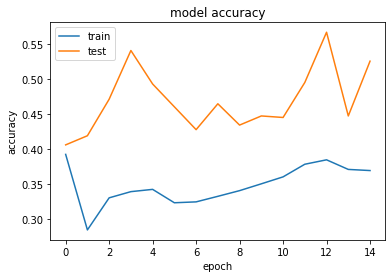

In [ ]:
epochs = 15#50
model, history = train(img_dim, epochs)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/MALIS/plots/CNN-history.png')

In [ ]:
model = load_model("/content/drive/My Drive/MALIS/models/CNN-0,46.h5")

In [ ]:
#ANALYSIS ON VALIDATION SET
pred = model.predict(x_test)

#convert array with values of form [[0.4, 0.6],...,[0.9, 0.1]] to [1,0] 
y_hat = np.zeros(len(pred))
for i in range(len(pred)):
    y_hat[i] = np.argmax(pred[i])

print("amount of times guessed abnormal", np.count_nonzero(y_hat==1))

kappa = cohen_kappa_score(Y_test, y_hat)
print ("cohen-kappa score is", kappa)

score = model.evaluate(x_test, Y_test_cat, verbose=0)
print("metrics are", model.metrics_names)
print("respective scores are", score)

amount of times guessed abnormal 197
cohen-kappa score is 0.45564242341940364
metrics are ['loss', 'acc']
respective scores are [0.6054434625998787, 0.73478264]


##PART 4: MULTI-INPUT CNN

In [ ]:
# We load the 1st picture, 2nd picture etc. of the patient in separate arrays
def load_multi(img_dim, path):
    test_df = pd.read_csv(path)
    test_df['DIAGNOSIS'] = test_df['DIAGNOSIS']
    PICS_PER_PATIENT = 4

    x1 = []
    x2 = []
    x3 = []
    x4 = []
    Y = np.zeros(len(test_df))

    for i in range(len(test_df)):
        dirList = os.listdir(test_df["PATH"][i])
        patient = []

        pic_count = 0
        for dir in dirList:
          if(pic_count<PICS_PER_PATIENT): #most have 2-3 pics, one patient has 5
            img = mpimg.imread(test_df["PATH"][i] + dir)     
            image_resized = resize(img, img_dim)
            patient.append(image_resized)
            pic_count = pic_count+1
        
        #adding empty pictures so that each patient has 4 pictures
        while pic_count<PICS_PER_PATIENT:
          patient.append(np.zeros(img_dim))
          pic_count = pic_count + 1

        x1.append(patient[0])
        x2.append(patient[1])
        x3.append(patient[2])
        x4.append(patient[3])
        Y[i] = test_df["DIAGNOSIS"][i]

    return np.asarray(x1),np.asarray(x2),np.asarray(x3),np.asarray(x4),np.asarray(Y)

In [ ]:
x_train1, x_train2, x_train3, x_train4, Y_train = load_multi(img_dim,'MURA-v1.1/train_labeled_studies.csv')
x_test1, x_test2, x_test3, x_test4, Y_test = load_multi(img_dim,'MURA-v1.1/valid_labeled_studies.csv')

In [ ]:
Y_train_cat = np_utils.to_categorical(Y_train, labels_amount)
Y_test_cat = np_utils.to_categorical(Y_test, labels_amount)

In [ ]:
def create_convolution_layers(input_img):
  kernel_size = (5, 5)
  pool_size = (3, 3)

  #try less filters if not training
  filters = 32 #128

  model = Conv2D(filters, (kernel_size[0], kernel_size[1]))(input_img)
  model = BatchNormalization()(model)
  model = ReLU()(model)

  model = Conv2D(filters, (kernel_size[0], kernel_size[1]), input_shape=img_dim)(model)
  model = BatchNormalization()(model)
  model = ReLU()(model)
  model = MaxPooling2D(pool_size[0], pool_size[1])(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(filters, (kernel_size[0], kernel_size[1]))(model)
  model = BatchNormalization()(model)
  model = ReLU()(model)
  model = MaxPooling2D(pool_size[0], pool_size[1])(model)
  model = Dropout(0.25)(model)

  model = Conv2D(filters, (kernel_size[0], kernel_size[1]))(model)
  model = BatchNormalization()(model)
  model = ReLU()(model)
  model = MaxPooling2D(pool_size[0], pool_size[1])(model)
  model = Dropout(0.5)(model)

  return model

In [ ]:
def train_multi_input():
  epochs = 5 #200
  batch_size = 16 #reduce if Out Of Memory/Resource Exhausted crash

  pic1_input = Input(shape=img_dim)
  pic1_model = create_convolution_layers(pic1_input)

  pic2_input = Input(shape=img_dim)
  pic2_model = create_convolution_layers(pic2_input)

  pic3_input = Input(shape=img_dim)
  pic3_model = create_convolution_layers(pic3_input)

  pic4_input = Input(shape=img_dim)
  pic4_model = create_convolution_layers(pic4_input)

  conv = concatenate([pic1_model, pic2_model, pic3_model, pic4_model])

  conv = Dropout(0.25)(conv)
  conv = Flatten()(conv)
  dense = Dense(128)(conv)
  dense = ReLU()(dense)
  dense = Dropout(0.25)(dense)
  dense = Dense(labels_amount)(conv)
  output = ReLU()(dense)
  model = Model(inputs=[pic1_input, pic2_input, pic3_input, pic4_input], outputs=[output])
  opt = keras.optimizers.Adam()

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  count0 = np.count_nonzero(Y_train==0)
  count1 = np.count_nonzero(Y_train==1)
  class_weight = {0:count1/(count1+count0), 1:1}

  checkpoint = ModelCheckpoint('/content/drive/My Drive/MALIS/models/multi-input.h5', monitor='val_acc',save_best_only=True)

  history = model.fit([x_train1, x_train2, x_train3, x_train4], Y_train_cat,
            batch_size=batch_size,
            epochs=epochs,
            validation_data = ([x_test1, x_test2, x_test3, x_test4], Y_test_cat),
            callbacks=[checkpoint],
            class_weight=class_weight)

  return model, history

Train on 2018 samples, validate on 167 samples
Epoch 1/5
2018/2018 [==============================] - 33s 16ms/step - loss: 0.5531 - acc: 0.3677 - val_loss: 0.7090 - val_acc: 0.5150
Epoch 2/5
2018/2018 [==============================] - 23s 12ms/step - loss: 0.3040 - acc: 0.3944 - val_loss: 0.6998 - val_acc: 0.5030
Epoch 3/5
2018/2018 [==============================] - 23s 12ms/step - loss: 0.3023 - acc: 0.3925 - val_loss: 0.7081 - val_acc: 0.5269
Epoch 4/5
2018/2018 [==============================] - 23s 11ms/step - loss: 0.3007 - acc: 0.3831 - val_loss: 0.6553 - val_acc: 0.5509
Epoch 5/5
2018/2018 [==============================] - 23s 12ms/step - loss: 0.2974 - acc: 0.4351 - val_loss: 0.6938 - val_acc: 0.5629


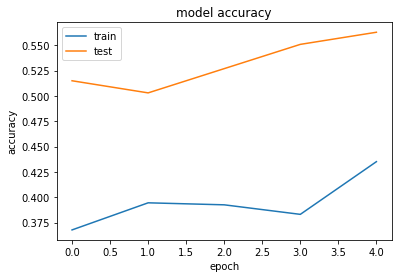

In [ ]:
model, history = train_multi_input()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/MALIS/plots/Multi-CNN-history.png')

In [ ]:
model = load_model("/content/drive/My Drive/MALIS/models/multi-input-0,4.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
final_loss, final_acc = model.evaluate([x_test1, x_test2, x_test3, x_test4], Y_test_cat, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

167/167 [==============================] - 2s 11ms/sample - loss: 0.6513 - acc: 0.7246
Final loss: 0.651328, final accuracy: 0.724551


In [ ]:
#ANALYSIS ON VALIDATION SET
from sklearn.metrics import cohen_kappa_score

pred = model.predict([x_test1, x_test2, x_test3, x_test4])

#convert array with values of form [[0.4, 0.6],...,[0.9, 0.1]] to [1,0] 
y_hat = np.zeros(len(pred))
for i in range(len(pred)):
    y_hat[i] = np.argmax(pred[i])

print("amount of times guessed abnormal", np.count_nonzero(y_hat==1))

kappa = cohen_kappa_score(Y_test, y_hat)
print ("cohen-kappa score is", kappa)

score = model.evaluate([x_test1, x_test2, x_test3, x_test4], Y_test_cat, verbose=0)
print("metrics are", model.metrics_names)
print("respective scores are", score)

amount of times guessed abnormal 54
cohen-kappa score is 0.4050495662949195
metrics are ['loss', 'acc']
respective scores are [0.6513284409117556, 0.7245509]
